# Cold Spring Harbor Deep Learning Tutorial 

Author: Nga Yu Lo (nyulo@flatironinstitute.org)

This tutorial has three parts. The first part gives an overview of pytorch. The second and third parts are demonstrations on analyzing deep neural network data that is comparative to neural data. 

1. [Training Neural Networks using Pytorch](#pytorch)
2. [Comparing representations](#comparing-representations)
3. [Manifold Geometry Analysis](#manifold-geometry-analysis)


# Training Neural Networks using Pytorch <a name="pytorch"></a>
The first part of this notebook demonstrates how to train neural networks using the pytorch library. Almost everything in this section can be found in the pytorch tutorial series. You are encouraged to look over the tutorial provided on pytorch. https://pytorch.org/tutorials/. The outline is as followed:

- [Dataset](#dataset) and [Dataloader](#dataloader)
- [Build your own feedforward model](#build)
- [Training feedforward model](#train)
- [Use a ImageNet-trained model](#pretrained)  
- [Extracting layer activations](#extract)

**Note: Pytorch uses tensors instead of numpy arrays.Generally, a numpy array can be converted to a tensor using torch.Tensor()**


In [4]:
import torch 
import numpy as np

X = [3,4,5]
A = np.array(X)
A

array([3, 4, 5])

In [5]:
tensor_A = torch.Tensor(A)
tensor_A

tensor([3., 4., 5.])

## Dataset <a name="dataset"></a>

For a simple feedforward neural network, pytorch expects datasets to be iterable, with each iteration providing the data itself and the labels. Pytorch provides several popular datasets, including MNIST (shown left), FashionMNIST, CIFAR10 (shown right), and CIFAR100. See https://pytorch.org/vision/stable/datasets.html#built-in-datasets for more.

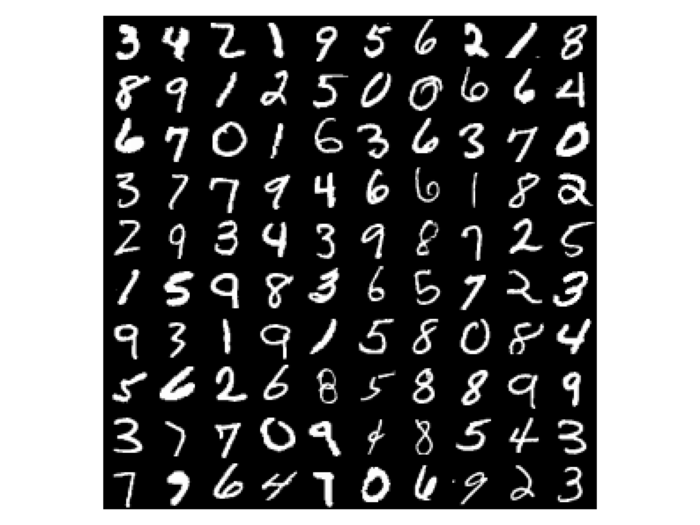
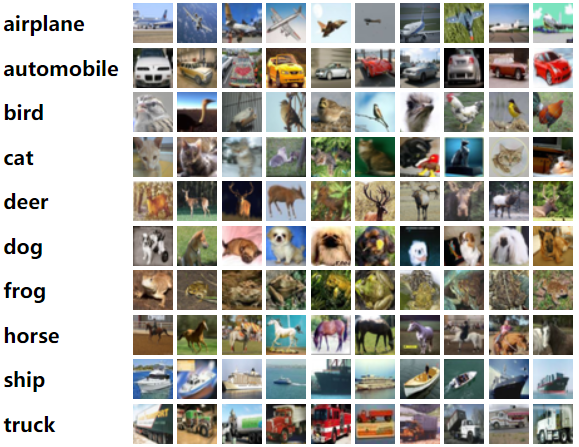

### Get data from pytorch

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Getting MNIST from the pytorch library. All datasets that are available on pytorch is separated with its training set and its test set
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%
69.6%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%
100.0%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Creating your own dataset

In [7]:
# You can define your own custom datasets. There are several ways of doing this depending on your needs, but pytorch does provide a template. 
#import os
#import pandas as pd
from torchvision.io import read_image

# Provide the csv file containing the labels of the images, the directory of the images on your local computer, any transformations to the images (transform) or the image labels (target_transform)
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# my_dataset = CustomImageDataset("labels.csv", os.getcwd()+"/my_images")

**The most important thing for the Dataset structure is that the __getitem__ function is defined such that either only the input data is returned or both the input data and the corresponding labels are returns together.**

## Dataloader <a name="dataloader"></a>

Before training your neural network, you must have your dataset in a dataloader structure. Dataloaders allow us to iterate through the dataset in batches and feed each batch into the neural network. 

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [9]:
# You can use a for loop to iterate through the dataloader 
for X,Y in train_dataloader:
  print(X.shape)
  print(Y.shape)
  break

# Alternatively, the following will providing the next batch everytime you call it
X, Y = next(iter(train_dataloader))

torch.Size([64, 1, 28, 28])
torch.Size([64])


Notice that size of the tensor is 4D. The first number indicates the batch size, that is how many instances are given to the neural network at a time. The rest of the numbers is the dimension of each instance. For images, you have the number of channels by the size of the image. In our example, MNIST images are 28x28 with one channel. 

## Build your own feedforward model <a name="build"></a>
 
We will build a feedforward model for classifying MNIST images. ANN are defined as classes in Pytorch. Each layer of the network is called and placed sequentially in the neural network. nn.Linear() indicates that the layer is fully connected. You provide the input dimension for that layer and the output dimension. The output dimension is the number of neurons in that layer. 

In [10]:
from torch import nn
class NeuralNetwork(nn.Module):
    # init defines the layers of the network in sequence. For each layer, you provide the input dimension and the output dimension
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()                     # Flatten the input
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 300),                      # Since MNIST has size 28x28, the input is a vector of length 28*28. In this first layer, we have 300 neurons 
            nn.ReLU(),                                  # We use RELU as an activation function
            nn.Linear(300, 300),                        # The second layer must have input dimension 300. The second layer has 300 neurons.  
            nn.ReLU(),
            nn.Linear(300, 10),                         # This is the output layer. The input dimension is 300. The output dimension is 10, because there are 10 classes in MNIST!!!
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Without training, let's get an prediction for our first batch! Observe the output shape is the batch size by the number of classes. The model gives a vector of probability of the image belonging to each class. 

In [14]:
my_model = NeuralNetwork()                    # Initiate the model
X, Y = next(iter(test_dataloader))
output = my_model(X)                        # You can call the neural network you built as a function
print(output.shape)


torch.Size([64, 10])


## Training feedforward model <a name="train"></a>

Let's return to training a simple feedforward neural network on MNIST. We will use the model and the dataloaders we defined earlier. To train, several hyperparameters must be given. This include the number of epochs (i.e. training time), the loss function, and the optimizer. You can also indicate the batch size you want. Sometimes, if your model is big, a smaller batch size will prevent your computer from crashing due to out of memory. For your optimizer, you can also indicate the learning rate you want. 

In [15]:
# Define hyparameters, loss function, and optimizer

learning_rate = 0.01            # learning rate
epochs = 20          # training time
batch_size = 64      

# Popular loss functions
# nn.MSELoss
# nn.CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()           # We will use cross entropy loss for our categorical data

# Popular Optimizers 
from torch.optim import SGD
optimizer = SGD(my_model.parameters(), lr = learning_rate)      # We will stochastic gradient descent as our optimizer


In [16]:
# We train our neural network using a loop calling a training function
def training_step(dataloader,model,loss_fn,optimizer):
  for X, Y in dataloader:
    pred = model(X)
    loss = loss_fn(pred,Y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  
  return loss

for epoch in range(epochs):
  loss = training_step(train_dataloader,my_model,loss_fn,optimizer)
  print(f"Epoch: {epoch}, Loss: {loss:>7f}")


Epoch: 0, Loss: 0.887258
Epoch: 1, Loss: 0.705539
Epoch: 2, Loss: 0.494564
Epoch: 3, Loss: 0.297656
Epoch: 4, Loss: 0.460312
Epoch: 5, Loss: 0.272949
Epoch: 6, Loss: 0.058212
Epoch: 7, Loss: 0.385666
Epoch: 8, Loss: 0.196735
Epoch: 9, Loss: 0.146666
Epoch: 10, Loss: 0.391414
Epoch: 11, Loss: 0.298120
Epoch: 12, Loss: 0.483343
Epoch: 13, Loss: 0.189728
Epoch: 14, Loss: 0.251191
Epoch: 15, Loss: 0.094290
Epoch: 16, Loss: 0.176625
Epoch: 17, Loss: 0.156359
Epoch: 18, Loss: 0.138520
Epoch: 19, Loss: 0.057867


Let's see how well our model predict.

In [17]:
# Testing step
def testing_step(dataloader,model,loss_fn):
  correct = 0
  for X, Y in dataloader:
    pred = model(X)
    correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
  return correct

correct = testing_step(test_dataloader,my_model,loss_fn)
size = len(test_dataloader.dataset)
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% \n")

Test Error: 
 Accuracy: 96.0% 



## Use a ImageNet-trained model <a name="pretrained"></a>

Pytorch provides imagenet trained convolutional neural network models in their torchvision library. We will call a resnet18 and have it classify CIFAR10 images. Be cautious that if you ask a pretrained model to make prediction on new data, the model expects the input to have been preprocessed the same way as the instances the model was trained on. For example, ImageNet instances have size 224x224. If you give the pretrained model a image in CIFARO10 of size 32x32, without resizing, it will perform poorly.   

In [18]:
from torchvision.models import resnet18, ResNet18_Weights

resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)
# Using pretrained models requires that your data be preprocessed in the way the model expects it
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()


In [19]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# the preprocess functions go into transform for your dataset
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=preprocess
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=preprocess
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

1.2%

100.0%


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [20]:
resnet_model.eval()                     # Set the model to .eval(). 

X,Y = next(iter(test_dataloader))
out = resnet_model(X)
print(out.shape)                        # The output shape is batch size x 1000, because imagenet has 1000 classes 


torch.Size([32, 1000])


## Extracting layer activations <a name="extract"></a>

Extracting layer activations can be useful for neuroscience. In Pytorch, to extract activations involve putting a forward hook on the layer you want and creating a dictionary to put the layer activations in. 

In [21]:
activation = {}                                       # activation is a global variable
def get_activation(name):                             # get_activation gets a name for the layer activation and and returns a hook
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [22]:
# Before extracting activations, it may be a good idea to see the architecture of the neural network. Use the following to see a list. 
list(resnet_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [23]:
# Let's supposed I want the activations after the relu layer in the first block of ResNet18. I would do register_forward_hook() on that layer

resnet_model.layer1[0].relu.register_forward_hook(get_activation('Resnet18_Relu1'))

After you placed the hook, give the the model input. The layer activations you want would automatically appear in your dictionary structure.  Notice the shape of your activations is 4d. The first number remains your batch size. 

In [24]:
X, Y = next(iter(test_dataloader))

output = resnet_model(X)
activation['Resnet18_Relu1'].shape     #Shape of activations

torch.Size([32, 64, 56, 56])

# Comparing representations <a name="comparing-representations"></a>

Having extracted activations, we can compare the representations of stimuli in the neural network. Here is a simple demonstration of a representational similarity analysis ([Kriegeskorte, 2008][1]) on layer activations of neural networks. We will compare the layer we just extracted and the same layer from an untrained ResNet18. You can replace one of the neural network activations with neural data to compare neural network representations with neural representations.

[1]: https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full#h3 

In [25]:
poor_resnet_model = resnet18()
poor_resnet_model.layer1[0].relu.register_forward_hook(get_activation('PoorResnet18_Relu1'))
otuput = poor_resnet_model(X)
activation['PoorResnet18_Relu1'].shape

torch.Size([32, 64, 56, 56])

In [27]:
# Flatten the feature dimensions of the activations to #instances x #features
X1 = activation["Resnet18_Relu1"].reshape((32,64*56*56))
X2 = activation["PoorResnet18_Relu1"].reshape((32,64*56*56))

# Simple RSA
import numpy as np
from scipy.stats import pearsonr 
def rdm(M):
  d = []
  for i in range(M.shape[0]):
    for j in range(i+1,M.shape[0]):
      r = pearsonr(M[i,:],M[j,:])[0]
      d.append(1-r)
  return d

def rsa(r1,r2):
  return pearsonr(r1,r2)[0]

r1 = rdm(X1)
r2 = rdm(X2)
print("The similarity score is: ", rsa(r1,r2))


The similarity score is:  0.41574222230516494


# Manifold Geometry Analysis (Advanced) <a name="manifold-geometry-analysis"></a>

Here, we performed the manifold geometry analysis on neural network data using pre-written functions in [chung-neuroai-lab/cshl2022-deep-learning-manifolds-tutorial][1]. 

If you use any of the functions provided in this github repo, please cite the following

```
@article{chung2018classification,
  title={Classification and geometry of general perceptual manifolds},
  author={Chung, SueYeon and Lee, Daniel D and Sompolinsky, Haim},
  journal={Physical Review X},
  volume={8},
  number={3},
  pages={031003},
  year={2018},
  publisher={APS}
}

@article{cohen2019separability,
  title={Separability and Geometry of Object Manifolds in Deep Neural Networks},
  author={Cohen, Uri and Chung, SueYeon and Lee, Daniel D and Sompolinsky, Haim},
  journal={bioRxiv},
  pages={644658},
  year={2019},
  publisher={Cold Spring Harbor Laboratory}
}
```

We will use utils to make manifold data as expected by the analyzing functions. Then, we use manifold_analysis.py to examine the data geometric properties. Functions in manifold_analysis.py expects input data as a list of numpy arrays. The length of list X should be the number of manifolds P. Each array should have shape (N,M) where N is the number of dimensions/features/neurons and M is the number of examples that the manifold consists of.  

**X = [(N_1,M_1), (N_2,M_2), ... (N_P,M_P)]**

[1]: https://github.com/chung-neuroai-lab/cshl2022-deep-learning-manifolds-tutorial

Please note that manifold_analysis.py does not account for manifold center correlation. Hence, capacity is poorly estimated. For a better estimate, use manifold_analysis_corr.py 


In this demonstration, we will analyze neural network data from a pretrained resnet18 given images from CIFAR100.

In [28]:
from utils.activation_extractor import *
from utils.make_manifold_data import * 

# To make manifold data, first load the model. We will load a pre-trained model and use stimuli from CIFAR100 
model = resnet18(weights=ResNet18_Weights)
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=preprocess
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=preprocess
)

model.eval();

/Users/nyulo/miniconda3/envs/tutorial/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.3%

100.0%


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [30]:
sampled_classes = 40
examples_per_class = 40
data = make_manifold_data(training_data,sampled_classes,examples_per_class)           # Given the data, the number of classes, and the number of examples per class, we get the data we want as input to the neural network
data = [d for d in data]
activations_dict = extractor(model,data,layer_nums=[3])                    # extract_activations uses the same strategy we discussed previously to get activations from specified layers. We can specify based on layer numbers or layer type (i.e. con2d, relu, etc)
                                                                                      
# Reshape the manifold data to the expected dimensions
for layer, activations in activations_dict.items():
    X = [d.reshape(d.shape[0],-1).T for d in activations]
    activations_dict[layer] = X
    

In [31]:
from manifold_geometry.manifold_analysis import *

kappa = 0    # Specify the margin (usually 0) 
n_t = 300    # Specify the number of Gaussian vectors to sample (200 or 300 is a good default) 

for layer, activations in activations_dict.items():
    alpha, radius, dimension = manifold_analysis(X,kappa,n_t)
    c = 1/np.mean(1/alpha)
    r = np.mean(radius)
    d = np.mean(dimension)
    print(f"{layer}, Capacity: {c}, Radius: {r}, Dimension: {d}")



layer_0_Input, Capacity: 0.10210382868414464, Radius: 1.165534398073706, Dimension: 16.234330064336838
layer_3_ReLU, Capacity: 0.10214180034859942, Radius: 1.1709662436924018, Dimension: 16.25642020167163
